# Analysis of Charles Murray's Basic Income Plan

Details from http://www.fljs.org/files/publications/Murray.pdf, based on *In Our Hands* (2006).

Key elements summarized in [Ghenis (2017)](https://medium.com/@MaxGhenis/the-case-for-a-person-centric-basic-income-plan-55e90010fc9e) include:

* Annual amount: \$10,000, plus \$3,000 to purchase catastrophic health insurance.
* Eligible population: 21+.
* Replaced plans: “Social Security, Medicare, Medicaid, welfare programmes, social service programmes, agricultural subsidies, and corporate welfare.” Per [The Atlantic (2006)](https://www.theatlantic.com/magazine/archive/2006/04/why-murrays-big-idea-wont-work/304830/), unemployment insurance will also end.
* Tax changes: 17% phase-out of basic income for incomes between \$30,000 to \$60,000 (\$5,000 for incomes above \$60,000).\*

This analysis considers only the \$10,000 amount, repealing non-healthcare safety net programs to avoid considering the effect on employer-sponsored health insurance.

TODO: Wait on new Medicare/Medicaid values.

\* *Murray's [2016 article](http://www.aei.org/publication/a-guaranteed-income-for-every-american/) says "After \$30,000, a graduated surtax reimburses part of the grant, which would drop to \$6,500 (but no lower) when an individual reaches \$60,000 of earned income." This includes the \$3,000 health insurance stipend.*

## Setup

### Imports

In [38]:
import taxcalc as tc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
tc.__version__

'0.19.0'

### Settings

In [40]:
sns.set_style('white')
DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [41]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [42]:
# Number of decimals when printing pandas DataFrames.
pd.set_option('precision', 2)

### Utilities

From https://stackoverflow.com/a/48999797/1840471.

In [7]:
def gini(x, w=None, zero_negatives=True):
    # Requires float numpy arrays (not pandas Series or lists) to work.
    x = np.array(x).astype('float')
    if zero_negatives:
        x[x < 0] = 0
    if w is not None:
        w = np.array(w).astype('float')
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        cumw = np.cumsum(sorted_w)
        cumxw = np.cumsum(sorted_x * sorted_w)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) /
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumxw = np.cumsum(sorted_x)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumxw) / cumxw[-1]) / n

2018 HHS Poverty Guidelines (Federal Poverty Level) for 48 Contiguous States and District of Columbia (Alaska and Hawaii have higher guidelines, but the data does not have state code): https://aspe.hhs.gov/poverty-guidelines

In [8]:
def fpl(XTOT):
    return 7820 + 4320 * XTOT

In [9]:
def weight(df, col):
    return df[col] * df.s006

def weighted_sum(df, col):
    return weight(df, col).sum()

def weighted_mean(df, col):
    return weighted_sum(df, col) / df.s006.sum()

In [10]:
def add_weighted_quantiles(df, col, weight='s006'):
    # weight: typically 's006' but can be something else to weight by people.
    df.sort_values(by=col, inplace=True)
    col_pctile = col + '_percentile_exact'
    df[col_pctile] = 100 * df[weight].cumsum() / df[weight].sum()
    # "Null out" negatives using -1, since integer arrays can't be NaN.
    # TODO: Should these be null floats?
    df[col_pctile] = np.where(df[col] >= 0, df[col_pctile], 0)
    # Reduce top record, otherwise it's incorrectly rounded up.
    df[col_pctile] = np.where(df[col_pctile] >= 99.99999, 99.99999, 
                              df[col_pctile])
    df[col + '_percentile'] = np.ceil(df[col_pctile]).astype(int)
    df[col + '_2percentile'] = np.ceil(df[col_pctile] / 2).astype(int)
    df[col + '_ventile'] = np.ceil(df[col_pctile] / 5).astype(int)
    df[col + '_decile'] = np.ceil(df[col_pctile] / 10).astype(int)
    df[col + '_quintile'] = np.ceil(df[col_pctile] / 20).astype(int)
    df[col + '_quartile'] = np.ceil(df[col_pctile] / 25).astype(int)
    return df

In [11]:
def quantile_summary(df, groupby):
    qs = df.groupby(groupby).sum()
    add_ratios(qs)
    # Exclude 0, the negative group.
    return qs.loc[1:]

### Constants

In [12]:
UBI = 10000.
PS_START = 30000.  # Per n21.
PS_END = 60000.  # Per n21.
MIN_UBI = 5000.  # For tax units with agi >= PS_END * n21.
ps = (UBI - MIN_UBI) / (PS_END - PS_START)
UBI_MULT = 0.82  # For revenue neutrality.

In [13]:
print('Phase-out rate: ' + '{:.1f}'.format(ps * 100) + '%')

Phase-out rate: 16.7%


## Data

In [14]:
recs = tc.Records.cps_constructor()
calc = tc.Calculator(records=recs, policy=tc.Policy(), verbose=False)
calc.advance_to_year(2018)
calc.calc_all()

Ordered biggest to smallest for charting.

In [15]:
# Exclude mcaid_ben and mcare_ben to focus on non-healthcare.
BENS = ['snap_ben', 'ssi_ben', 'housing_ben',
        'tanf_ben', 'vet_ben', 'wic_ben', 'other_ben', 
        'e02300',  # e02300 is unemployment insurance benefits.
        'e02400']  # e02400 is OASDI.
OTHER_COLS = ['XTOT', 'expanded_income', 'aftertax_income', 'n21', 'nu18',
              'age_head', 'age_spouse', 'elderly_dependent',
              'c00100']  # AGI.

In [16]:
tu = calc.dataframe(['s006'] + BENS + OTHER_COLS)
tu.rename(columns={'aftertax_income': 'afti_base'}, inplace=True)

## Preprocess

### Add UBI, benefit total, and difference

In [17]:
tu['c00100_per_n21'] = tu.c00100 / tu.n21
tu['ubi_per_n21'] = (
    UBI_MULT * np.where(tu.c00100_per_n21 <= PS_START, UBI,
                        np.where(tu.c00100_per_n21 >= PS_END, MIN_UBI,
                                 UBI - (ps * (tu.c00100_per_n21 - PS_START)))))
tu['ubi'] = np.where(tu.n21 == 0, 0, tu.n21 * tu.ubi_per_n21)

In [18]:
tu['bens'] = tu[BENS].sum(axis=1)

In [19]:
tu['ubi_minus_bens'] = tu.ubi - tu.bens

In [20]:
tu['afti_ubi'] = tu.afti_base + tu.ubi_minus_bens
tu['afti_ubi_pp'] = tu.afti_ubi / tu.XTOT

### Add quantiles

In [21]:
tu['XTOT_s006'] = weight(tu, 'XTOT')
tu['afti_base_pp'] = tu.afti_base / tu.XTOT
tu = add_weighted_quantiles(tu, 'afti_base', 'XTOT_s006')
tu = add_weighted_quantiles(tu, 'afti_base_pp', 'XTOT_s006')
tu = add_weighted_quantiles(tu, 'expanded_income', 'XTOT_s006')

### Other additional columns

In [22]:
tu['nu18_bucket'] = np.where(tu.nu18 < 3, tu.nu18.astype('int'), '3+')
tu['has_nu18'] = tu.nu18 > 0
tu['has_e02400'] = tu.e02400 > 0  # OASDI.
tu['n65'] = ((tu.age_head >= 65).astype('int') + 
             (tu.age_spouse >= 65).astype('int') + tu.elderly_dependent)
tu['has_n65'] = tu.n65 > 0

Check distribution of people by whether their tax unit has minors or OASDI recipients.

In [23]:
(100 * tu.groupby(['has_nu18', 'has_n65']).XTOT_s006.sum() / 
 tu.XTOT_s006.sum()).reset_index()

,has_nu18,has_n65,XTOT_s006
0,False,False,36.56
1,False,True,15.48
2,True,False,46.12
3,True,True,1.84


### Weighted sums

In [24]:
# Add weighted sums.
tu['s006_m'] = tu.s006 / 1e6
tu['s006_b'] = tu.s006 / 1e9
tu['expanded_income_b'] = tu.expanded_income * tu.s006_b
tu['afti_base_b'] = tu.afti_base * tu.s006_b
tu['afti_ubi_b'] = tu.afti_ubi * tu.s006_b
tu['XTOT_m'] = tu.XTOT * tu.s006_m
tu['nu18_m'] = tu.nu18 * tu.s006_m
tu['n65_m'] = tu.n65 * tu.s006_m

### Summarize quantiles

In [25]:
def add_ratios(df):
    df['afti_base_pp'] = 1000 * df.afti_base_b / df.XTOT_m
    df['afti_ubi_pp'] = 1000 * df.afti_ubi_b / df.XTOT_m
    df['afti_chg_b'] = df.afti_ubi_b - df.afti_base_b
    df['afti_pctchg'] = 100 * df.afti_chg_b / df.afti_base_b

SUM_COLS = ['s006', 'XTOT_m', 'afti_base_b', 'afti_ubi_b']

def quantile_summary(df, groupby):
    qs = df.groupby(groupby)[SUM_COLS].sum()
    add_ratios(qs)
    # Exclude 0, the negative group.
    return qs.loc[1:]

In [26]:
add_ratios(tu)
tu['abs_afti_pctchg'] = tu.afti_pctchg.abs()

In [27]:
tu[tu.abs_afti_pctchg == tu.abs_afti_pctchg.max()]

,s006,snap_ben,ssi_ben,housing_ben,tanf_ben,vet_ben,wic_ben,other_ben,e02300,e02400,...,s006_b,expanded_income_b,afti_base_b,afti_ubi_b,XTOT_m,nu18_m,n65_m,afti_chg_b,afti_pctchg,abs_afti_pctchg
329713,560.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.61e-07,0.0,0.0,4.60e-03,1.12e-03,5.61e-04,0.00e+00,4.60e-03,inf,inf
329647,703.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.03e-07,0.0,0.0,5.76e-03,1.41e-03,7.03e-04,0.00e+00,5.76e-03,inf,inf
73716,402.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.03e-07,0.0,0.0,6.60e-03,1.21e-03,4.03e-04,0.00e+00,6.60e-03,inf,inf
163853,507.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.08e-07,0.0,0.0,8.32e-03,1.02e-03,0.00e+00,0.00e+00,8.32e-03,inf,inf
277757,955.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.55e-07,0.0,0.0,1.57e-02,1.91e-03,0.00e+00,0.00e+00,1.57e-02,inf,inf
203841,1740.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.74e-06,0.0,0.0,2.85e-02,3.48e-03,0.00e+00,0.00e+00,2.85e-02,inf,inf
36621,1047.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.05e-06,0.0,0.0,1.72e-02,2.10e-03,0.00e+00,0.00e+00,1.72e-02,inf,inf
23811,569.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.70e-07,0.0,0.0,9.34e-03,2.28e-03,5.70e-04,0.00e+00,9.34e-03,inf,inf
240520,608.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.09e-07,0.0,0.0,9.98e-03,2.43e-03,6.09e-04,0.00e+00,9.98e-03,inf,inf
329352,495.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.95e-07,0.0,0.0,4.06e-03,2.97e-03,2.48e-03,0.00e+00,4.06e-03,inf,inf


In [28]:
quart = quantile_summary(tu, 'afti_base_pp_quartile')
quint = quantile_summary(tu, 'afti_base_pp_quintile')
dec = quantile_summary(tu, 'afti_base_pp_decile')
vent = quantile_summary(tu, 'afti_base_pp_ventile')
twopct = quantile_summary(tu, 'afti_base_pp_2percentile')
pct = quantile_summary(tu, 'afti_base_pp_percentile')

In [29]:
quart_by_nu18b = quantile_summary(tu, ['afti_base_pp_quartile', 'nu18_bucket'])
quint_by_nu18b = quantile_summary(tu, ['afti_base_pp_quintile', 'nu18_bucket'])
dec_by_nu18b = quantile_summary(tu, ['afti_base_pp_decile', 'nu18_bucket'])
vent_by_nu18b = quantile_summary(tu, ['afti_base_pp_ventile', 'nu18_bucket'])
twopct_by_nu18b = quantile_summary(tu, ['afti_base_pp_2percentile', 'nu18_bucket'])
pct_by_nu18b = quantile_summary(tu, ['afti_base_pp_percentile', 'nu18_bucket'])

In [30]:
quart_by_nu18 = quantile_summary(tu, ['afti_base_pp_quartile', 'has_nu18'])
quint_by_nu18 = quantile_summary(tu, ['afti_base_pp_quintile', 'has_nu18'])
dec_by_nu18 = quantile_summary(tu, ['afti_base_pp_decile', 'has_nu18'])
vent_by_nu18 = quantile_summary(tu, ['afti_base_pp_ventile', 'has_nu18'])
twopct_by_nu18 = quantile_summary(tu, ['afti_base_pp_2percentile', 'has_nu18'])
pct_by_nu18 = quantile_summary(tu, ['afti_base_pp_percentile', 'has_nu18'])

In [31]:
quart_by_n65 = quantile_summary(tu, ['afti_base_pp_quartile', 'has_n65'])
quint_by_n65 = quantile_summary(tu, ['afti_base_pp_quintile', 'has_n65'])
dec_by_n65 = quantile_summary(tu, ['afti_base_pp_decile', 'has_n65'])
vent_by_n65 = quantile_summary(tu, ['afti_base_pp_ventile', 'has_n65'])
twopct_by_n65 = quantile_summary(tu, ['afti_base_pp_2percentile', 'has_n65'])
pct_by_n65 = quantile_summary(tu, ['afti_base_pp_percentile', 'has_n65'])

## Analysis

### Totals

In [32]:
XTOT_in_tus_0_n21 = tu[tu.n21 == 0].XTOT_s006.sum()
print(('{:.1f} million people ({:.1f}% of all people) are in tax units ' +
       'without an adult over age 21.').format(
    XTOT_in_tus_0_n21 / 1e6, 100 * XTOT_in_tus_0_n21 / tu.XTOT_s006.sum()))

9.4 million people (2.8% of all people) are in tax units without an adult over age 21.


In [33]:
print(
    'Total benefit value: ${:,.2f}T'.format(
        weighted_sum(tu, 'bens') / 1e12) + '\n' +
    'Total proposed UBI: ${:,.2f}T'.format(
        weighted_sum(tu, 'ubi') / 1e12))

Total benefit value: $1.57T
Total proposed UBI: $1.61T


### Quantile distributions

In [34]:
def quantile_plot(df, legend_title, xlabel, title):
    fig = plt.figure()
    ax = df.unstack(level=1).afti_pctchg.plot()
    plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
    if legend_title is not None:
        plt.legend(title=legend_title)
    sns.despine(left=True, bottom=True)
    ax.set(xlabel=xlabel, ylabel='Change to income after taxes and transfers')
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y / 100)))
    plt.title(title, loc='left')
    #return(fig)
    plt.show()

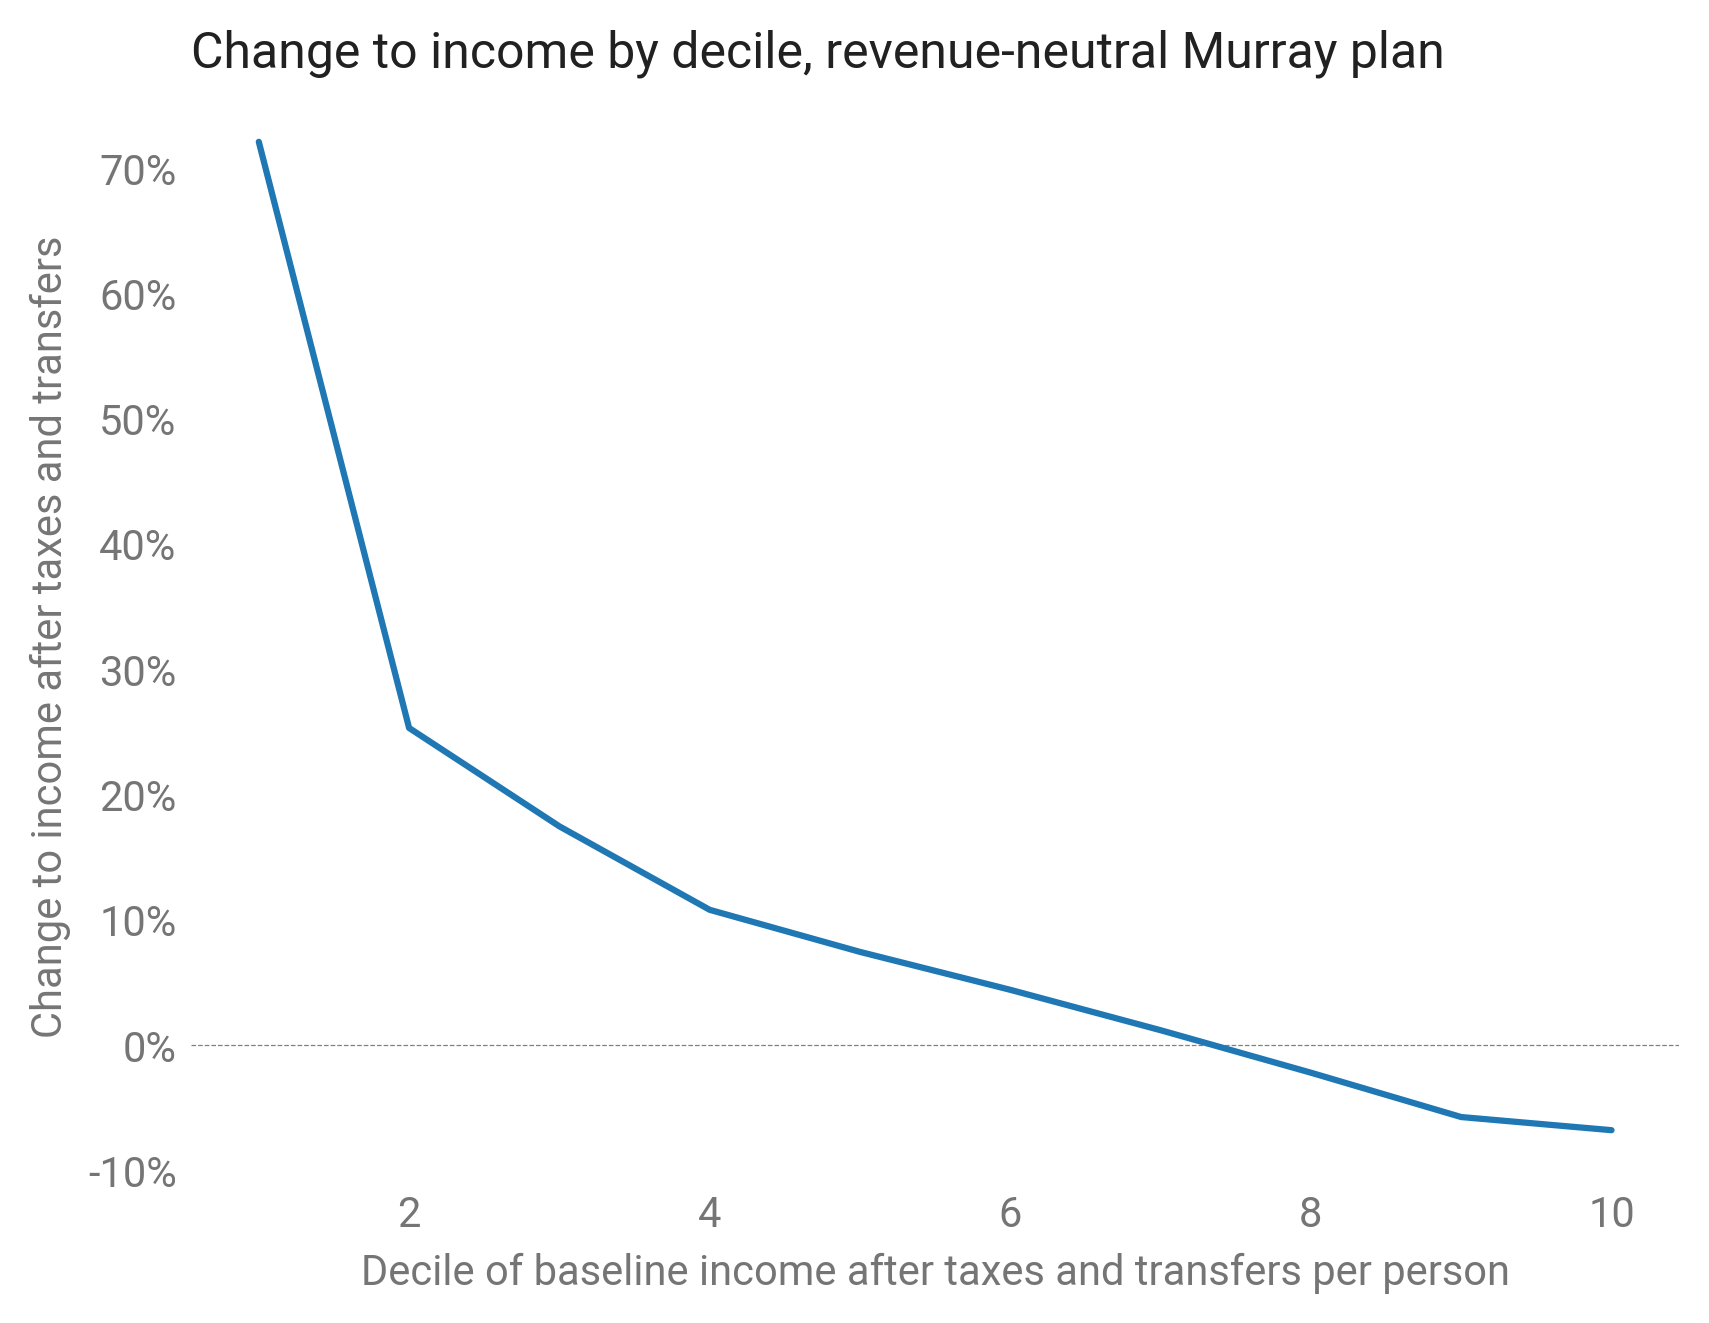

In [35]:
ax = quantile_plot(dec, 
                   None, 
                   'Decile of baseline income after taxes and transfers per person',
                   'Change to income by decile, ' + 'revenue-neutral Murray plan')
# ax.set(xticks=[1, 2, 3, 4])
# plt.show()

<Figure size 1920x1440 with 0 Axes>

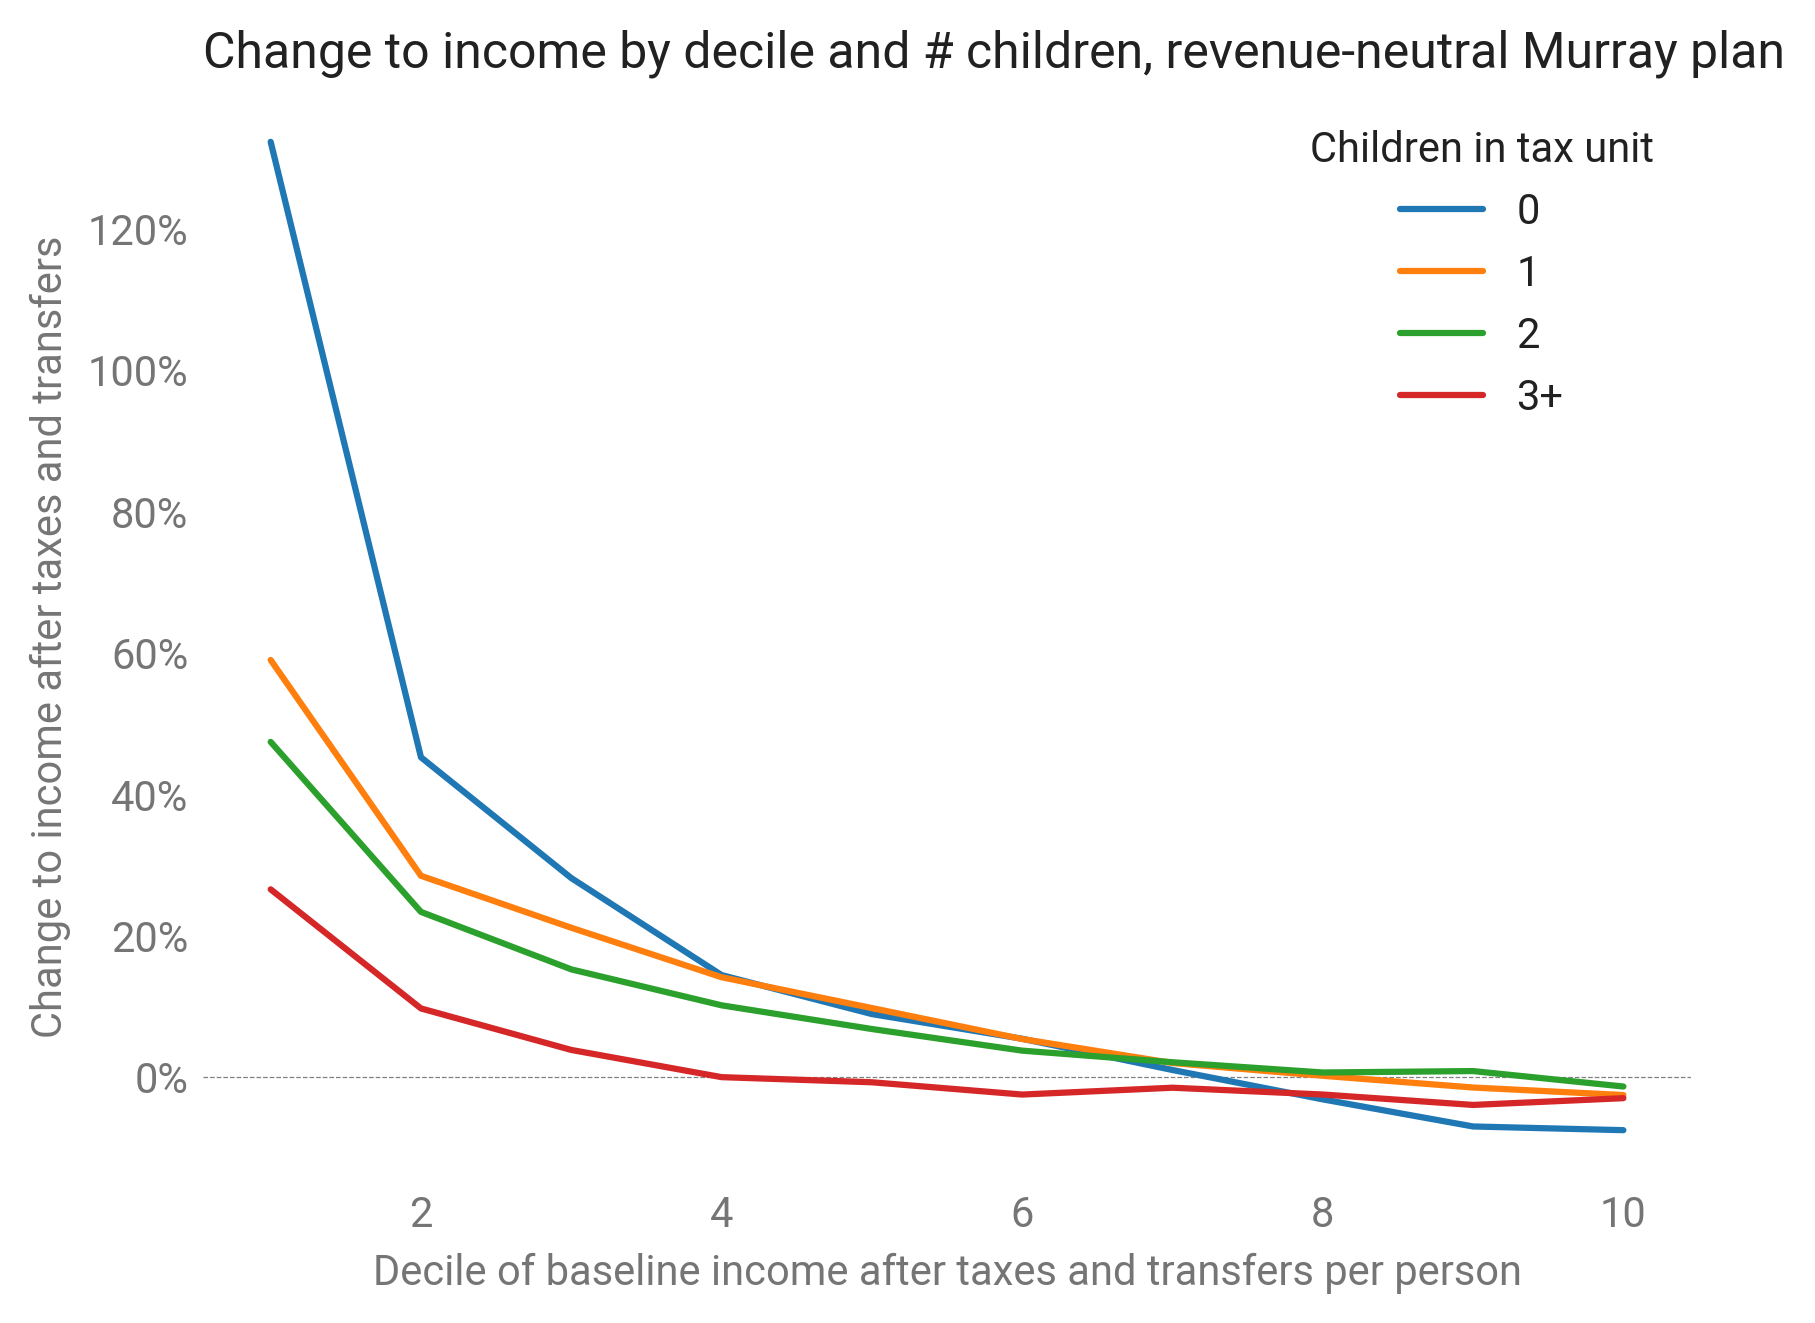

In [36]:
quantile_plot(dec_by_nu18b, 
              'Children in tax unit', 
              'Decile of baseline income after taxes and transfers per person',
              'Change to income by decile and # children, ' +
              'revenue-neutral Murray plan')
# plt.show()

<Figure size 1920x1440 with 0 Axes>

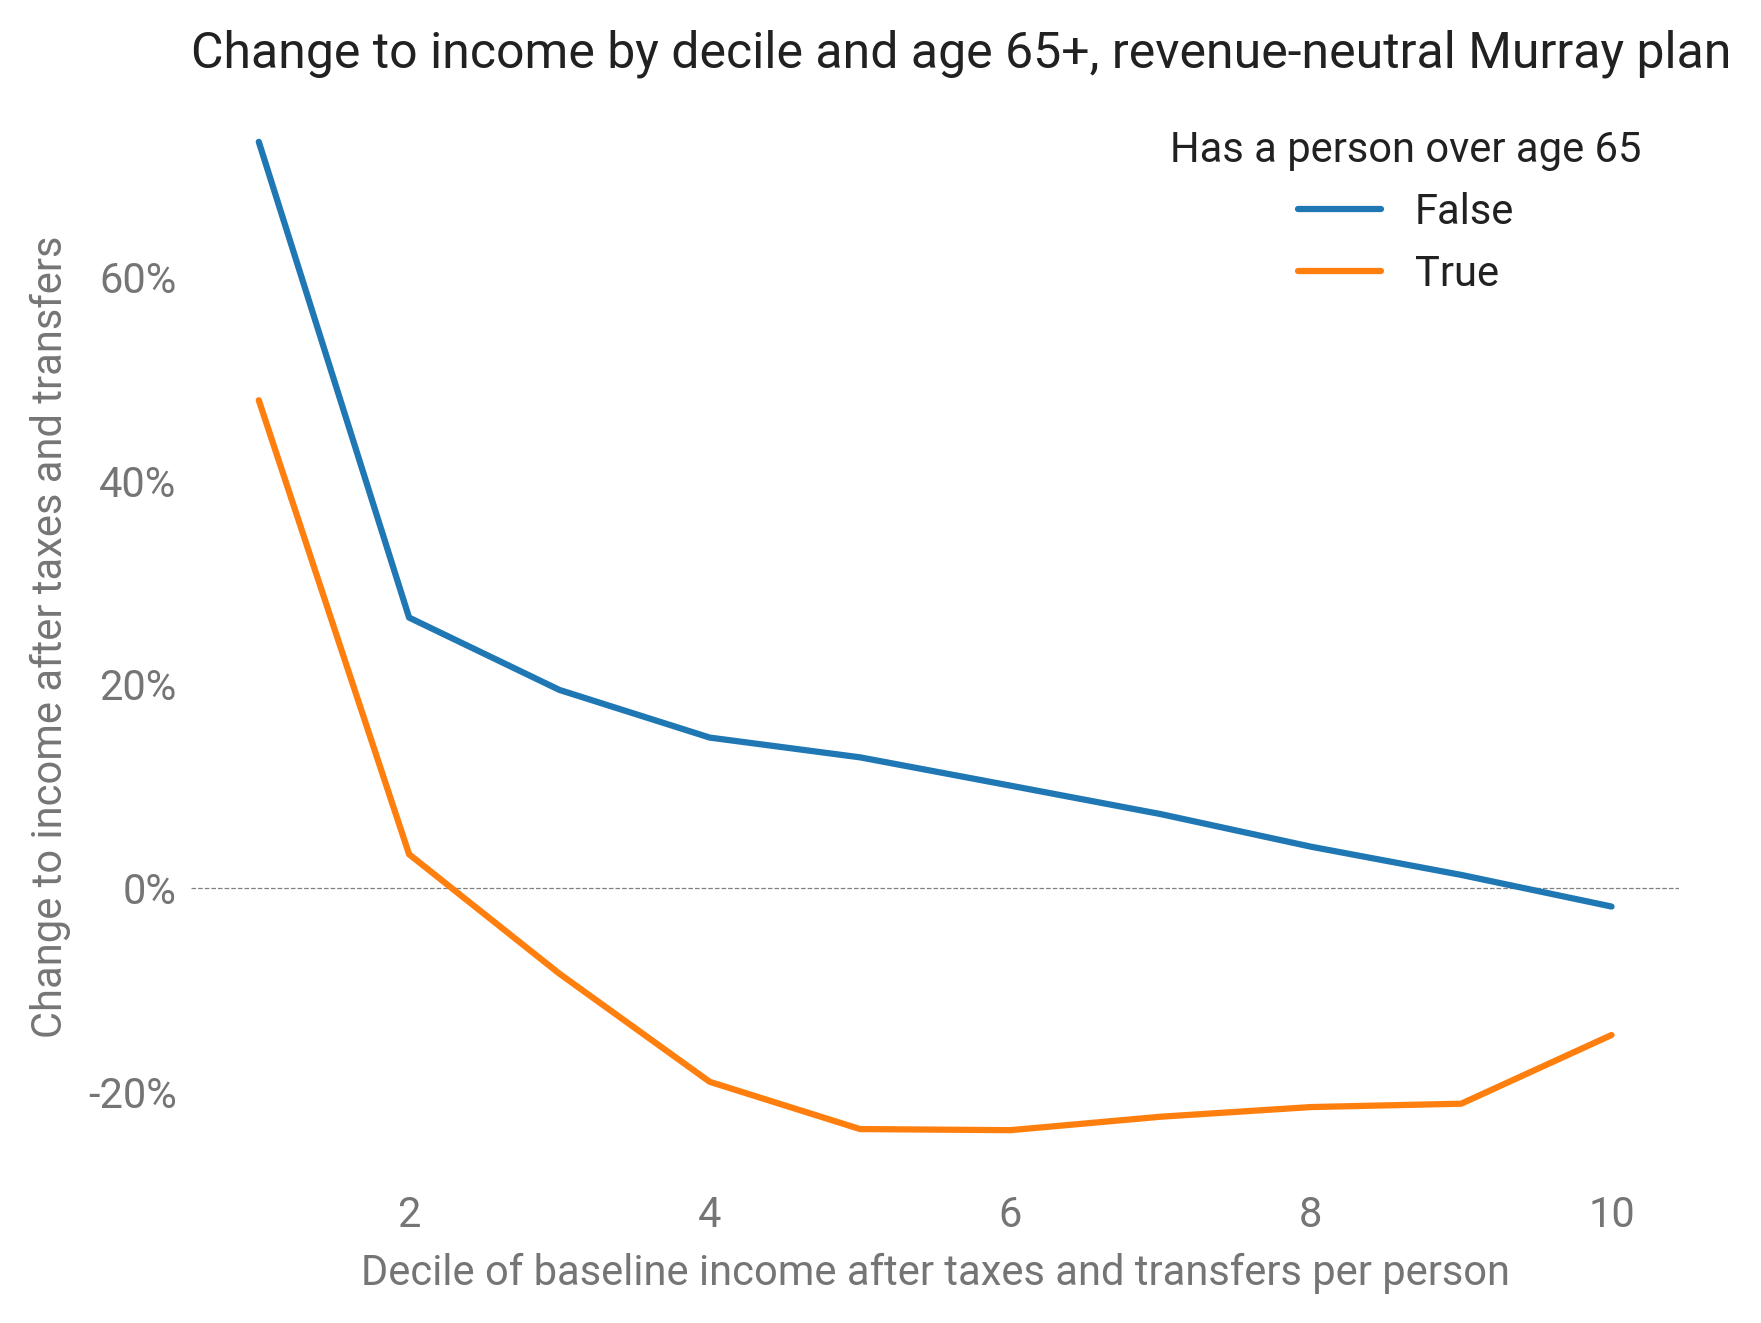

In [37]:
quantile_plot(dec_by_n65, 
              'Has a person over age 65', 
              'Decile of baseline income after taxes and transfers per person',
              'Change to income by decile and age 65+, ' +
              'revenue-neutral Murray plan')
plt.show()

### Inequality

In [35]:
tu.columns

Index([u's006', u'snap_ben', u'ssi_ben', u'housing_ben', u'tanf_ben',
       u'vet_ben', u'wic_ben', u'other_ben', u'e02300', u'e02400', u'XTOT',
       u'expanded_income', u'afti_base', u'n21', u'nu18', u'age_head',
       u'age_spouse', u'elderly_dependent', u'c00100', u'c00100_per_n21',
       u'ubi_per_n21', u'ubi', u'bens', u'ubi_minus_bens', u'afti_ubi',
       u'afti_ubi_pp', u'XTOT_s006', u'afti_base_pp',
       u'afti_base_percentile_exact', u'afti_base_percentile',
       u'afti_base_2percentile', u'afti_base_ventile', u'afti_base_decile',
       u'afti_base_quintile', u'afti_base_quartile',
       u'afti_base_pp_percentile_exact', u'afti_base_pp_percentile',
       u'afti_base_pp_2percentile', u'afti_base_pp_ventile',
       u'afti_base_pp_decile', u'afti_base_pp_quintile',
       u'afti_base_pp_quartile', u'expanded_income_percentile_exact',
       u'expanded_income_percentile', u'expanded_income_2percentile',
       u'expanded_income_ventile', u'expanded_income_decile',
  

In [36]:
gini(tu.afti_base, tu.s006)

0.47543199269126346

In [37]:
gini(tu.afti_ubi, tu.s006)

0.45851583663950346

In [38]:
gini(tu.afti_base_pp, tu.XTOT_s006)

0.45844418996074437

In [39]:
gini(tu.afti_ubi_pp, tu.XTOT_s006)

0.42825670096670237

### Poverty

In [52]:
fpl(2)

16460

In [40]:
tu['fpl'] = fpl(tu.XTOT)
tu['fpl_pp'] = tu.fpl / tu.XTOT
# Using $10k per person.
tu['pov_10k'] = 10000 * tu.XTOT
# $1.90 per day in 2011 dollars = $2.10 in 2018 dollars = $780/year.
EXTREME_POVERTY_LINE = 780
tu['extreme_pov'] = EXTREME_POVERTY_LINE * tu.XTOT

In [41]:
def pov_rate(metric, afti, pov_line):
    return ((tu[metric] * (tu[afti] < tu[pov_line])).sum() / 
                      tu[metric].sum())

In [42]:
AFTI_COLS = ['afti_base', 'afti_ubi']
pov = pd.DataFrame([(metric, afti, pov_line) 
                    for metric in ['XTOT_m', 'nu18_m', 'n65_m']
                    for afti in AFTI_COLS
                    for pov_line in ['fpl', 'pov_10k', 'extreme_pov']])
pov.columns = ['metric', 'afti', 'pov_line']
pov['pov_rate'] = pov.apply(lambda x: pov_rate(x.metric, x.afti, x.pov_line), 
                            axis=1)

In [43]:
pov

,metric,afti,pov_line,pov_rate
0,XTOT_m,afti_base,fpl,8.75e-02
1,XTOT_m,afti_base,pov_10k,1.44e-01
2,XTOT_m,afti_base,extreme_pov,1.39e-02
3,XTOT_m,afti_ubi,fpl,7.66e-02
4,XTOT_m,afti_ubi,pov_10k,1.13e-01
5,XTOT_m,afti_ubi,extreme_pov,3.31e-03
6,nu18_m,afti_base,fpl,9.50e-02
7,nu18_m,afti_base,pov_10k,2.22e-01
8,nu18_m,afti_base,extreme_pov,1.68e-02
9,nu18_m,afti_ubi,fpl,9.21e-02


In [44]:
pov_wide_XTOT = pov[pov.metric == 'XTOT_m'].pivot_table(
    index='pov_line', columns='afti')
pov_wide_XTOT.columns = AFTI_COLS
pov_wide_XTOT = pov_wide_XTOT[AFTI_COLS]

pov_wide_nu18 = pov[pov.metric == 'nu18_m'].pivot_table(
    index='pov_line', columns='afti')
pov_wide_nu18.columns = AFTI_COLS
pov_wide_nu18 = pov_wide_nu18[AFTI_COLS]

pov_wide_n65 = pov[pov.metric == 'n65_m'].pivot_table(
    index='pov_line', columns='afti')
pov_wide_n65.columns = AFTI_COLS
pov_wide_n65 = pov_wide_n65[AFTI_COLS]

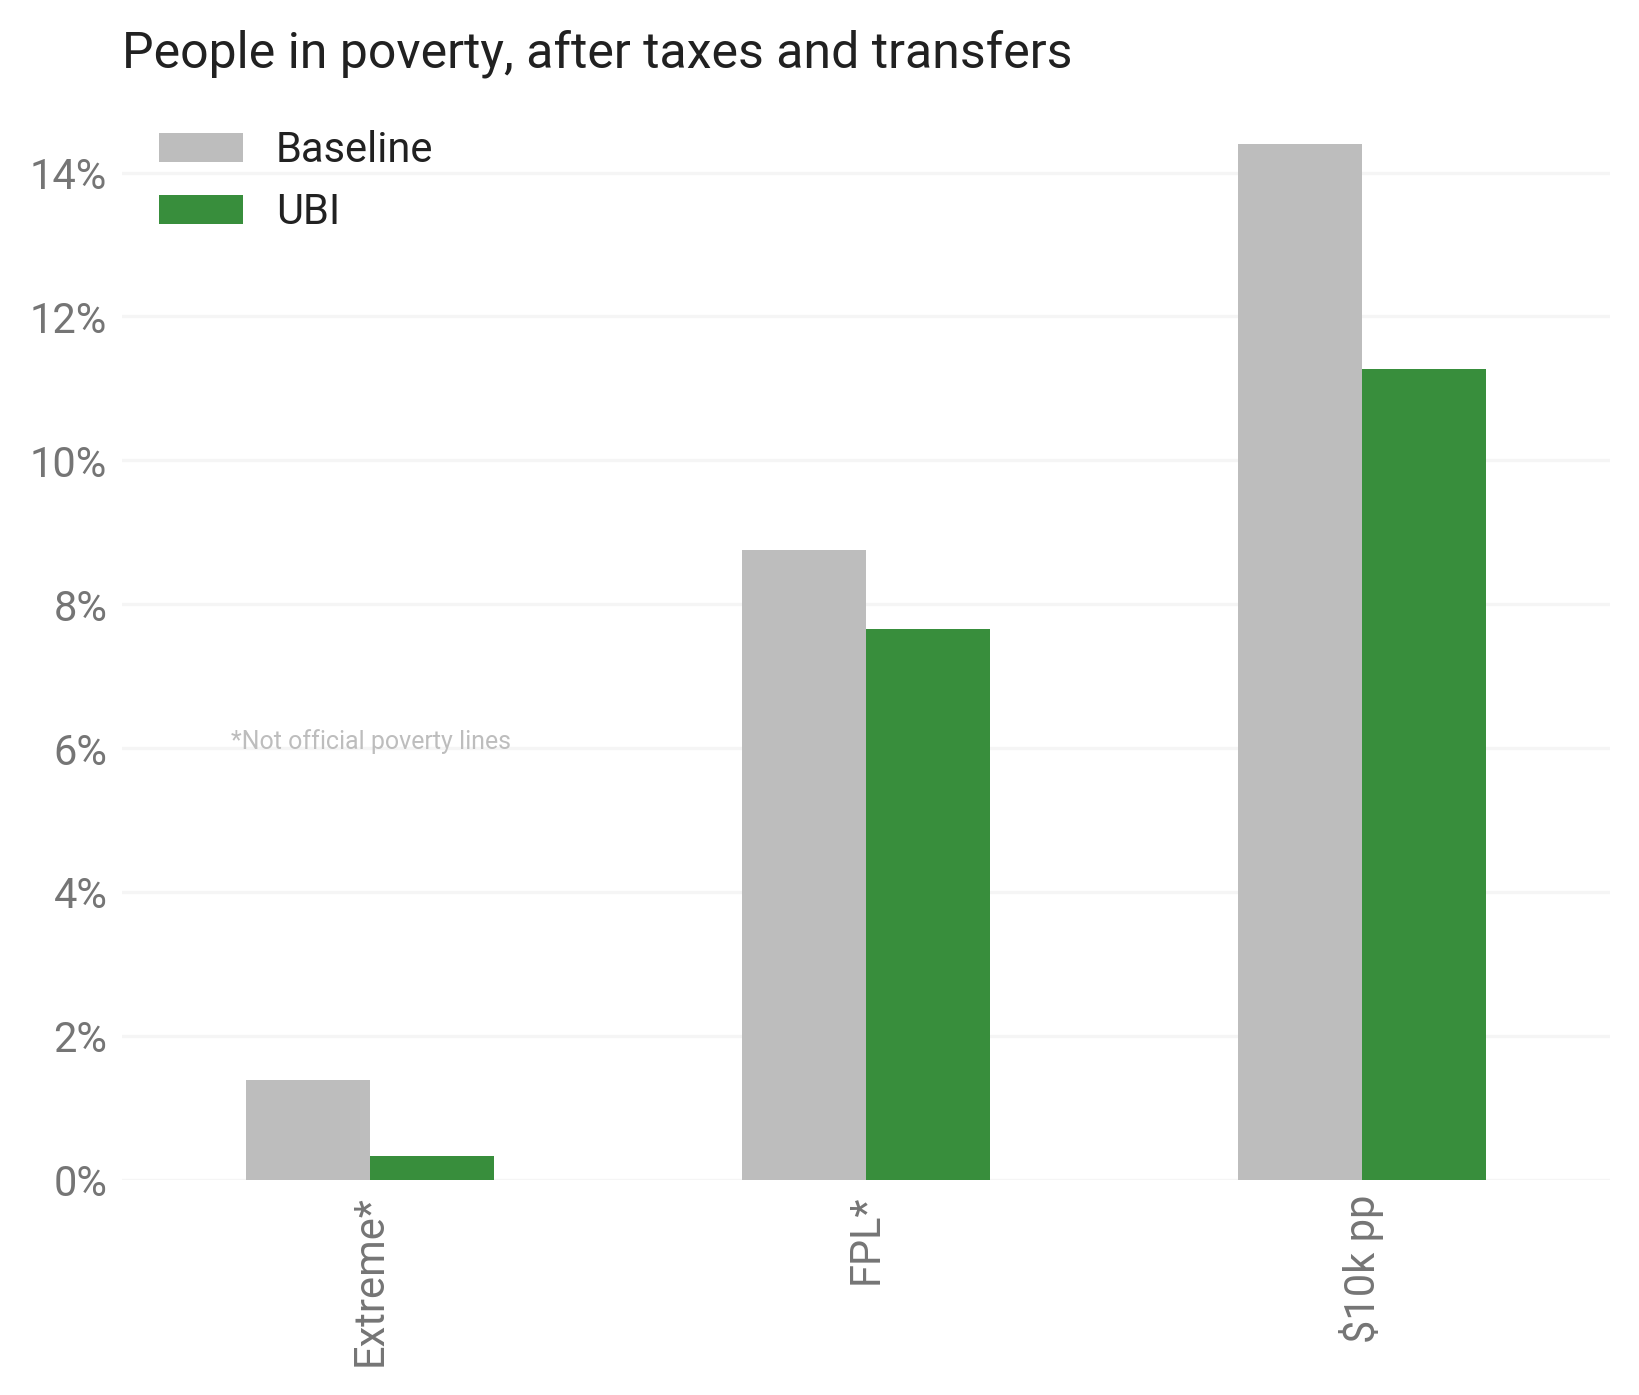

In [45]:
KEEP_COLOR = '#bdbdbd'  # Light gray from material.io/color.
UBI_COLOR = '#388e3c'
ax = pov_wide_XTOT.plot.bar(color=[KEEP_COLOR, UBI_COLOR])
ax.set_xticklabels(('Extreme*', 'FPL*', '$10k pp'))
sns.despine(left=True, bottom=True)
# Use text instead of legend.
# ax.legend_.remove()
LEFT_X = -0.28
ax.legend(['Baseline', 'UBI'])
# ax.text(LEFT_X, 0.235, 'Repeal CTC', horizontalalignment='left',
#         color=REPEAL_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.225, 'No change to CTC', horizontalalignment='left',
#         color=KEEP_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.215, rn_ubi_str + ' child benefit', 
#         horizontalalignment='left', color=UBI_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.205, '$2,000 child benefit', 
#         horizontalalignment='left', color=TUBI_COLOR, size=8, weight='bold')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
plt.title('People in poverty, after taxes and transfers', 
          loc='left')
ax.text(LEFT_X, 0.06, '*Not official poverty lines',
        horizontalalignment='left', color=KEEP_COLOR, size=6)
ax.set(xlabel='')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

In [46]:
pov_wide_nu18

,afti_base,afti_ubi
pov_line,,
extreme_pov,0.02,5.41e-03
fpl,0.10,9.21e-02
pov_10k,0.22,1.82e-01


In [47]:
pov_wide_XTOT

,afti_base,afti_ubi
pov_line,,
extreme_pov,0.01,3.31e-03
fpl,0.09,7.66e-02
pov_10k,0.14,1.13e-01


In [58]:
pov_wide_nu18.afti_ubi / pov_wide_nu18.afti_base - 1

pov_line
extreme_pov   -0.68
fpl           -0.03
pov_10k       -0.18
dtype: float64

In [59]:
pov_wide_n65.afti_ubi / pov_wide_n65.afti_base - 1

pov_line
extreme_pov   -0.56
fpl            3.17
pov_10k        2.10
dtype: float64

In [61]:
pov_wide_XTOT.afti_ubi / pov_wide_XTOT.afti_base - 1

pov_line
extreme_pov   -0.76
fpl           -0.13
pov_10k       -0.22
dtype: float64

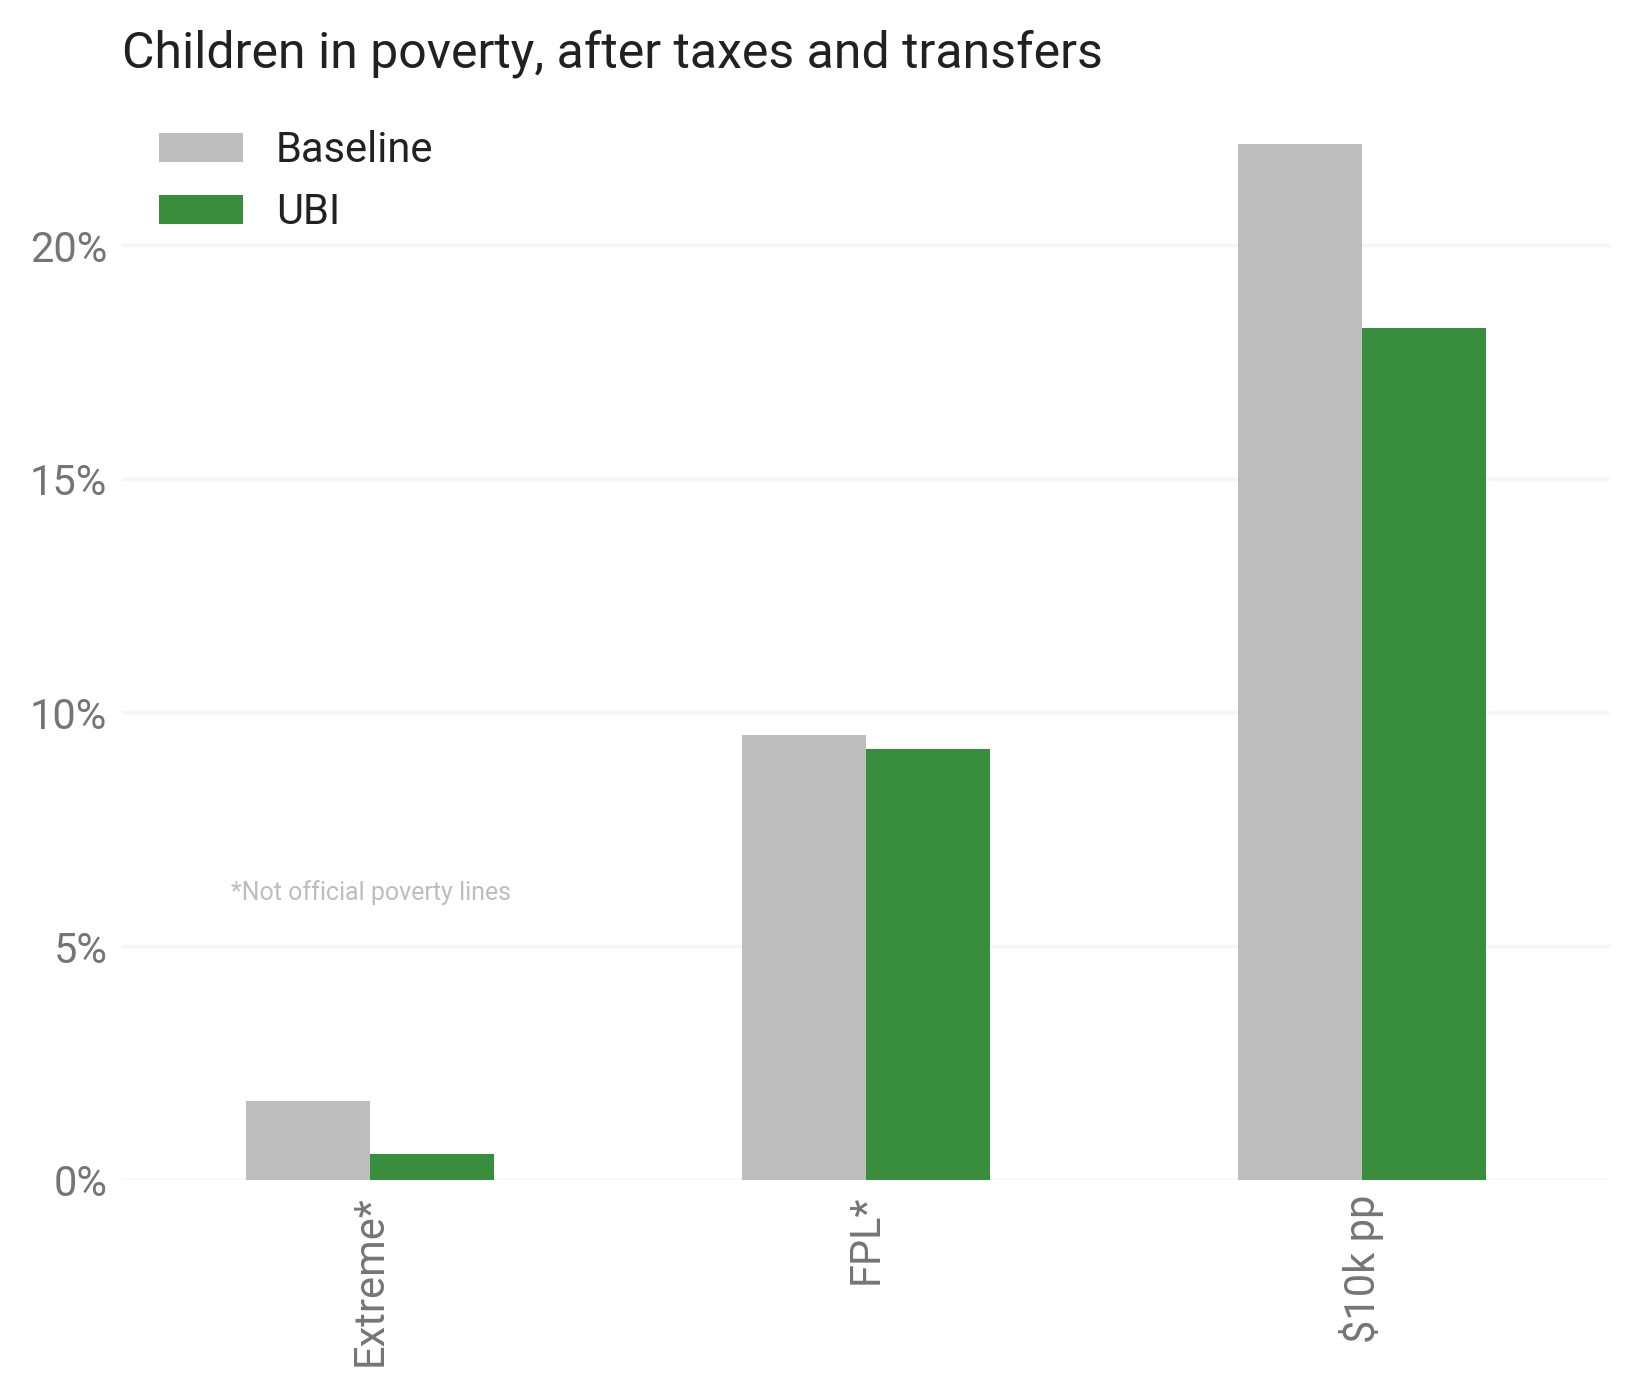

In [48]:
KEEP_COLOR = '#bdbdbd'  # Light gray from material.io/color.
UBI_COLOR = '#388e3c'
ax = pov_wide_nu18.plot.bar(color=[KEEP_COLOR, UBI_COLOR])
ax.set_xticklabels(('Extreme*', 'FPL*', '$10k pp'))
sns.despine(left=True, bottom=True)
# Use text instead of legend.
# ax.legend_.remove()
LEFT_X = -0.28
ax.legend(['Baseline', 'UBI'])
# ax.text(LEFT_X, 0.235, 'Repeal CTC', horizontalalignment='left',
#         color=REPEAL_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.225, 'No change to CTC', horizontalalignment='left',
#         color=KEEP_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.215, rn_ubi_str + ' child benefit', 
#         horizontalalignment='left', color=UBI_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.205, '$2,000 child benefit', 
#         horizontalalignment='left', color=TUBI_COLOR, size=8, weight='bold')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
plt.title('Children in poverty, after taxes and transfers', 
          loc='left')
ax.text(LEFT_X, 0.06, '*Not official poverty lines',
        horizontalalignment='left', color=KEEP_COLOR, size=6)
ax.set(xlabel='')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

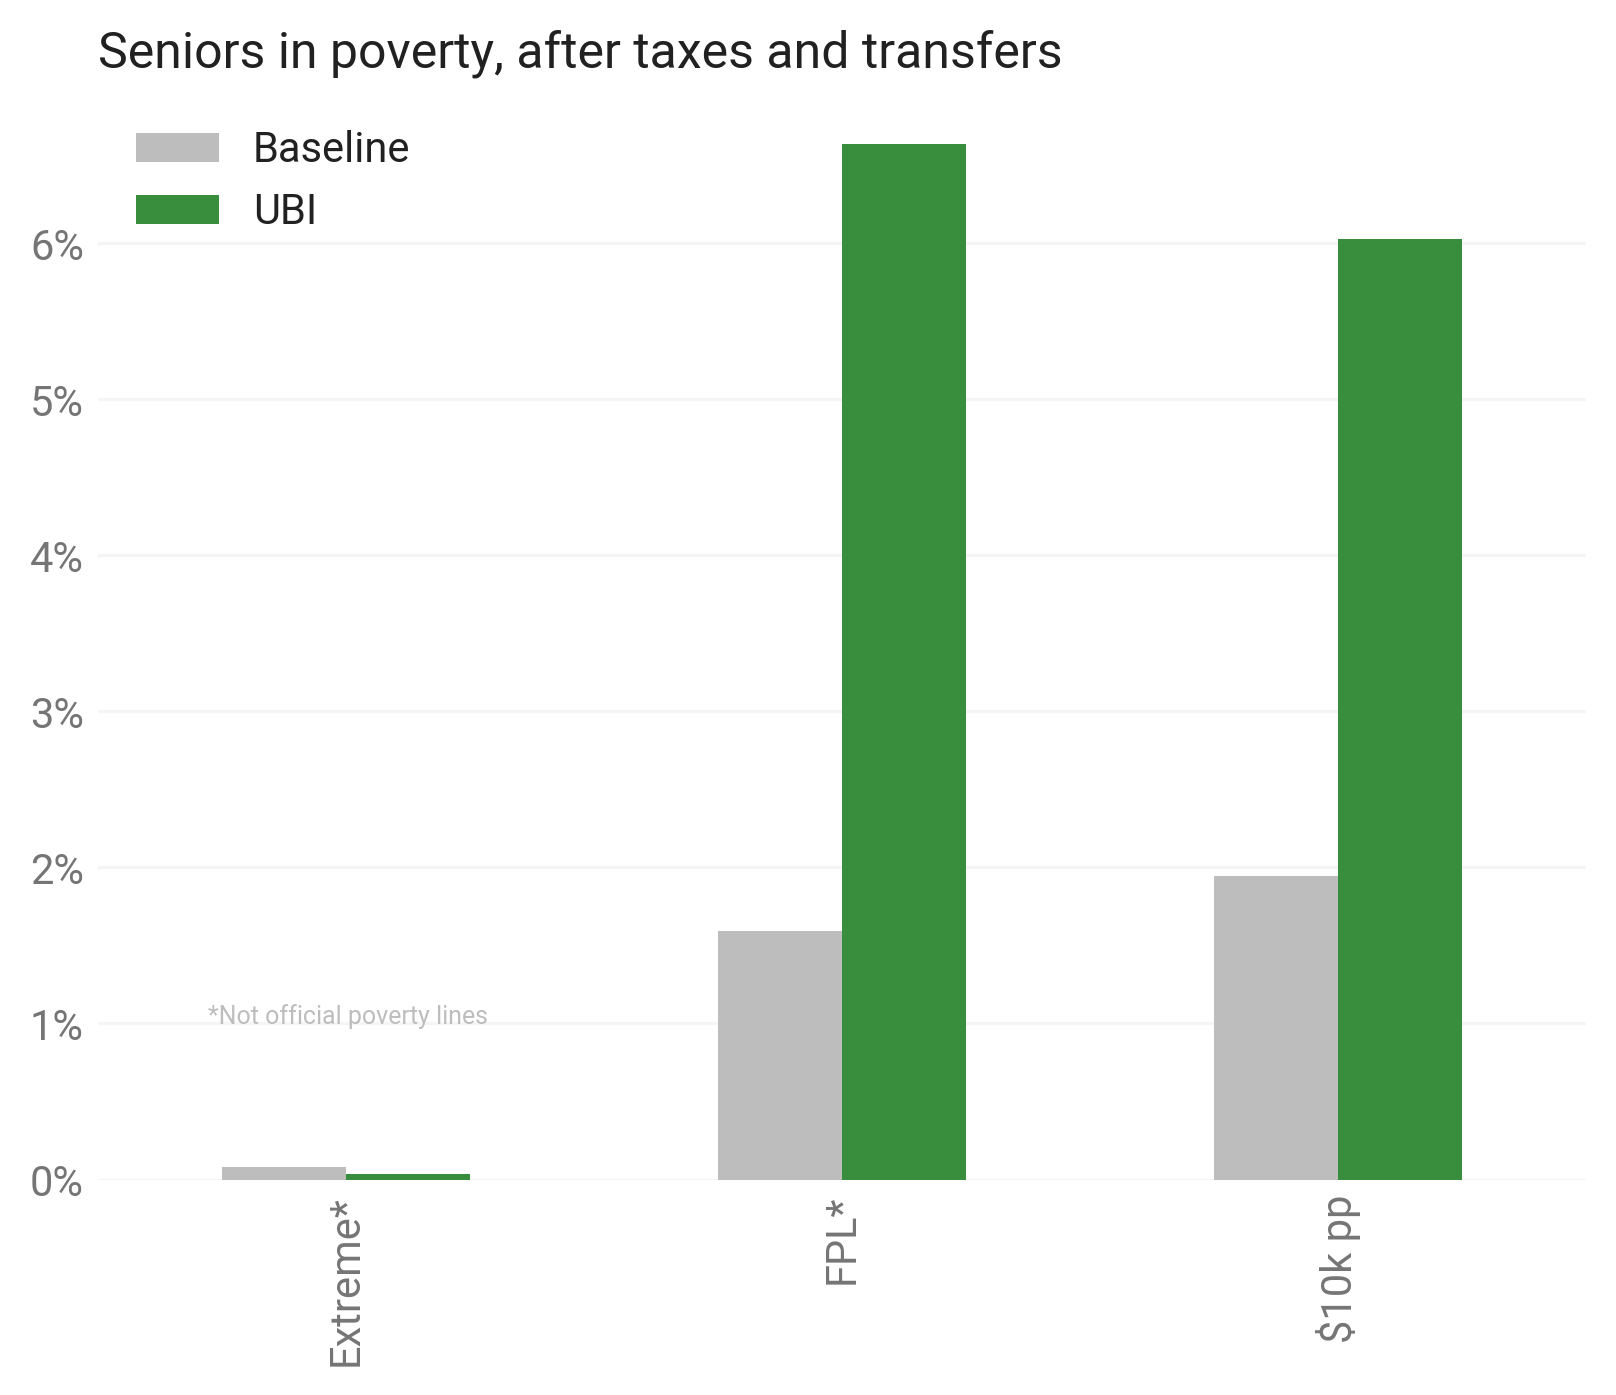

In [49]:
KEEP_COLOR = '#bdbdbd'  # Light gray from material.io/color.
UBI_COLOR = '#388e3c'
ax = pov_wide_n65.plot.bar(color=[KEEP_COLOR, UBI_COLOR])
ax.set_xticklabels(('Extreme*', 'FPL*', '$10k pp'))
sns.despine(left=True, bottom=True)
# Use text instead of legend.
# ax.legend_.remove()
LEFT_X = -0.28
ax.legend(['Baseline', 'UBI'])
# ax.text(LEFT_X, 0.235, 'Repeal CTC', horizontalalignment='left',
#         color=REPEAL_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.225, 'No change to CTC', horizontalalignment='left',
#         color=KEEP_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.215, rn_ubi_str + ' child benefit', 
#         horizontalalignment='left', color=UBI_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.205, '$2,000 child benefit', 
#         horizontalalignment='left', color=TUBI_COLOR, size=8, weight='bold')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
plt.title('Seniors in poverty, after taxes and transfers', 
          loc='left')
ax.text(LEFT_X, 0.01, '*Not official poverty lines',
        horizontalalignment='left', color=KEEP_COLOR, size=6)
ax.set(xlabel='')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

### Disruption

#### Share with >10% loss

In [43]:
(tu[(tu.afti_base > 0) & (tu.afti_pctchg > 10)].s006.sum() /
 tu[(tu.afti_base > 0)].s006.sum())

0.42592574818622114

In [44]:
(tu[(tu.afti_base > 0) & (tu.afti_pctchg < -30)].s006.sum() /
 tu[(tu.afti_base > 0)].s006.sum())

0.11730817297426552

In [60]:
# Use least or min instead.
tu['afti_pctchg_neg'] = np.where((tu.afti_pctchg > 0) | (tu.afti_base <= 0), 
                                 0, tu.afti_pctchg)

In [66]:
tu[tu.afti_pctchg_neg == tu.afti_pctchg_neg.min()].transpose()

,334767
s006,6.8e+02
snap_ben,0
ssi_ben,0
housing_ben,0
tanf_ben,0
vet_ben,0
wic_ben,0
other_ben,3.8e+02
e02300,0
e02400,0


In [64]:
tu[tu.afti_pctchg_neg == tu.afti_pctchg_neg.min()][['afti_base', 'afti_ubi']]

,afti_base,afti_ubi
334767,65.94,-315.71


In [68]:
tu.afti_pctchg_neg.min()

-578.7599906043081

In [67]:
weighted_mean(tu, 'afti_pctchg_neg')

-8.477021840087517

In [ ]:
tu.afti

#### Median absolute difference

In [70]:
tu.columns

Index([u's006', u'snap_ben', u'ssi_ben', u'housing_ben', u'tanf_ben',
       u'vet_ben', u'wic_ben', u'other_ben', u'e02300', u'e02400', u'XTOT',
       u'expanded_income', u'afti_base', u'n21', u'nu18', u'age_head',
       u'age_spouse', u'elderly_dependent', u'c00100', u'c00100_per_n21',
       u'ubi_per_n21', u'ubi', u'bens', u'ubi_minus_bens', u'afti_ubi',
       u'afti_ubi_pp', u'XTOT_s006', u'afti_base_pp',
       u'afti_base_percentile_exact', u'afti_base_percentile',
       u'afti_base_2percentile', u'afti_base_ventile', u'afti_base_decile',
       u'afti_base_quintile', u'afti_base_quartile',
       u'afti_base_pp_percentile_exact', u'afti_base_pp_percentile',
       u'afti_base_pp_2percentile', u'afti_base_pp_ventile',
       u'afti_base_pp_decile', u'afti_base_pp_quintile',
       u'afti_base_pp_quartile', u'expanded_income_percentile_exact',
       u'expanded_income_percentile', u'expanded_income_2percentile',
       u'expanded_income_ventile', u'expanded_income_decile',
  